Load Training Pilots txt
Load dataset
length of testing channel response 290000
INFO:tensorflow:Restoring parameters from C:/Users/aputilin/Desktop/Machine Learning/model_final2


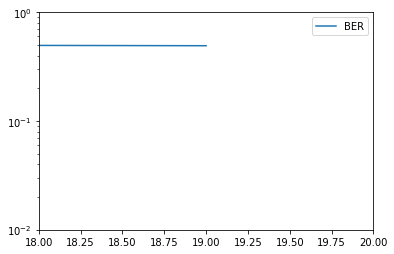

In [16]:
from __future__ import division
import numpy as np
import scipy.interpolate 
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os
%matplotlib inline
K = 64
CP = K//4
P = 64 # number of pilot carriers per OFDM block
#pilotValue = 1+1j
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.
#pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
#P = P+1
dataCarriers = np.delete(allCarriers, pilotCarriers)
mu = 2
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

payloadBits_per_OFDM = K*mu

SNRdb = 20  # signal to noise-ratio in dB at the receiver 

mapping_table = {
    (0,0) : -1-1j,
    (0,1) : -1+1j,
    (1,0) : 1-1j,
    (1,1) : 1+1j,
}

demapping_table = {v : k for k, v in mapping_table.items()}

def Modulation(bits):                                        
    bit_r = bits.reshape((int(len(bits)/mu), mu))                  
    return (2*bit_r[:,0]-1)+1j*(2*bit_r[:,1]-1)                                    # This is just for QAM modulation

def OFDM_symbol(Data, pilot_flag):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    #symbol = np.zeros(K) 
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = Data  # allocate the pilot subcarriers
    return symbol

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

def channel(signal,channelResponse,SNRdb):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

def removeCP(signal):
    return signal[CP:(CP+K)]

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)


def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

def get_payload(equalized):
    return equalized[dataCarriers]


def PS(bits):
    return bits.reshape((-1,))




def ofdm_simulate(codeword, channelResponse,SNRdb):       
    OFDM_data = np.zeros(K, dtype=complex)
    OFDM_data[allCarriers] = pilotValue
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX, channelResponse,SNRdb)
    OFDM_RX_noCP = removeCP(OFDM_RX)

    # ----- target inputs ---
    symbol = np.zeros(K, dtype=complex)
    codeword_qam = Modulation(codeword)
    symbol[np.arange(K)] = codeword_qam
    OFDM_data_codeword = symbol
    OFDM_time_codeword = np.fft.ifft(OFDM_data_codeword)
    OFDM_withCP_cordword = addCP(OFDM_time_codeword)
    OFDM_RX_codeword = channel(OFDM_withCP_cordword, channelResponse,SNRdb)
    OFDM_RX_noCP_codeword = removeCP(OFDM_RX_codeword)
    return np.concatenate((np.concatenate((np.real(OFDM_RX_noCP),np.imag(OFDM_RX_noCP))), np.concatenate((np.real(OFDM_RX_noCP_codeword),np.imag(OFDM_RX_noCP_codeword))))), abs(channelResponse) 


Pilot_file_name = 'Pilot_'+str(P)
if os.path.isfile(Pilot_file_name):
    print ('Load Training Pilots txt')
    # load file
    bits = np.loadtxt(Pilot_file_name, delimiter=',')
else:
    # write file
    bits = np.random.binomial(n=1, p=0.5, size=(K*mu, ))
    np.savetxt(Pilot_file_name, bits, delimiter=',')


pilotValue = Modulation(bits)

### =================== Deep Learning Training ================


def training():     
        # Training parameters
        training_epochs = 1
        batch_size = 256
        display_step = 1
        test_step = 1000
        examples_to_show = 10   
        # Network Parameters
        n_hidden_1 = 500
        n_hidden_2 = 250 # 1st layer num features
        n_hidden_3 = 120 # 2nd layer num features
        n_input = 256  
        n_output = 16 # every 16 bit are predicted by a model
        # tf Graph input (only pictures)
        X = tf.placeholder("float", [None, n_input])
        Y = tf.placeholder("float", [None, n_output])
        def encoder(x):
            weights = {                    
                'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],stddev=0.1)),
                'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],stddev=0.1)),
                'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3],stddev=0.1)),
                'encoder_h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_output],stddev=0.1)),            
            }
            biases = {            
                'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1],stddev=0.1)),
                'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2],stddev=0.1)),
                'encoder_b3': tf.Variable(tf.truncated_normal([n_hidden_3],stddev=0.1)),
                'encoder_b4': tf.Variable(tf.truncated_normal([n_output],stddev=0.1)),          
            
            }
        
            # Encoder Hidden layer with sigmoid activation #1
            #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
            layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
            layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
            layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
            layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['encoder_h4']), biases['encoder_b4']))
            return layer_4


        
        y_pred = encoder(X)
        # Targets (Labels) are the input data.
        y_true = Y
        
        init = tf.global_variables_initializer()

        # Define loss and optimizer, minimize the squared error
        
        # The H information set
        H_folder_test = 'C:/Users/aputilin/Desktop/Machine Learning/OFDM_DNN-master/H_dataset/Test/'
        test_idx_low = 301
        test_idx_high = 330
        # Saving Channel conditions to a large matrix
        channel_response_set_train = []
        print("Load dataset")
        channel_response_set_test = []
        for test_idx in range(test_idx_low,test_idx_high):
            H_file = H_folder_test + str(test_idx) + '.txt'
            with open(H_file) as f:
                for line in f:
                    numbers_str = line.split()
                    numbers_float = [float(x) for x in numbers_str]
                    h_response = np.asarray(numbers_float[0:int(len(numbers_float)/2)])+1j*np.asarray(numbers_float[int(len(numbers_float)/2):len(numbers_float)])
                    channel_response_set_test.append(h_response)

        print ('length of testing channel response', len(channel_response_set_test))
        with tf.Session() as sess:
            sess.run(init)
            saver = tf.train.import_meta_graph('C:/Users/aputilin/Desktop/Machine Learning/model_final2.meta')
          #  saver.restore(sess,'C:/Users/aputilin/Desktop/Machine Learning/model_final2')
            saver.restore(sess, tf.train.latest_checkpoint('C:/Users/aputilin/Desktop/Machine Learning/'))


            s = [i for i in range(18,20)]
            BER = np.zeros(len(s))
            input_samples_test = []
            input_labels_test = []
            k = 0
            test_number = 1000
            for iSNR in range(18,20): 
                    for i in range(0, test_number):
                        bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))                        
                        channel_response= channel_response_set_test[np.random.randint(0,len(channel_response_set_test))]
                        signal_output, para = ofdm_simulate(bits,channel_response,iSNR)
                        input_labels_test.append(bits[16:32])
                        input_samples_test.append(signal_output)
                    batch_x = np.asarray(input_samples_test)
                    batch_y = np.asarray(input_labels_test)
                    encode_decode = sess.run(y_pred, feed_dict = {X:batch_x})
                    mean_error_rate = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_y-0.5),tf.float32))),1))
                    BER[k] = mean_error_rate.eval({X:batch_x})
                    k = k+1;
                    
            plt.yscale('log')
            plt.axis([18, 20, 0.01, 1]) 
            plt.plot(s,BER,label = 'BER' )
            plt.legend()
            
            
            
    
training()

